### IMPORTING LIBRARIES

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
# import opendatasets as od
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name='indian-sign-language'

### Preparing the Indian Sign Language Dataset

Descritpion

![image-here](https://i.imgur.com/xB0s72x.png)


Let's begin by downloading the dataset and creating PyTorch datasets to load the data.

In [3]:
data_dir = './data/'
classes = os.listdir(data_dir)
print(classes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [4]:
# Let's evaluate a single class say "A"
A_file=os.listdir(data_dir+"A")
print("NO. of Training examples for Man:",len(A_file))
print(A_file[:5])

NO. of Training examples for Man: 1200
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']


In [5]:
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+i))
print(di)

{'1': 1200, '2': 1200, '3': 1200, '4': 1200, '5': 1200, '6': 1200, '7': 1200, '8': 1200, '9': 1200, 'A': 1200, 'B': 1200, 'C': 1200, 'D': 1200, 'E': 1200, 'F': 1200, 'G': 1200, 'H': 1200, 'I': 1200, 'J': 1200, 'K': 1200, 'L': 1200, 'M': 1200, 'N': 1200, 'O': 1200, 'P': 1200, 'Q': 1200, 'R': 1200, 'S': 1200, 'T': 1200, 'U': 1200, 'V': 1200, 'W': 1200, 'X': 1200, 'Y': 1200, 'Z': 1200}


First let's see a batch of raw images from the dataset. We will just import the dataloader to load the raw images. We will also create a helper function that will show us a batch of the image if we pass a DataLoader in it.

In [6]:
target_num = len(classes)
target_num

35

In [7]:
# THe below function will print a batch of 64 images from the dataset

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [8]:
raw_images = ImageFolder(data_dir, tt.ToTensor())

Let's see how a single image looks.

Dimension: torch.Size([3, 128, 128])


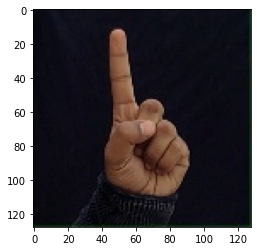

In [9]:
image, label = raw_images[0]
print("Dimension:", image.shape)
plt.imshow(image.permute(1, 2, 0))

In [10]:
# Let's create a dataloader for raw images
raw_dl = DataLoader(raw_images, 400, shuffle=True, num_workers=2, pin_memory=True)

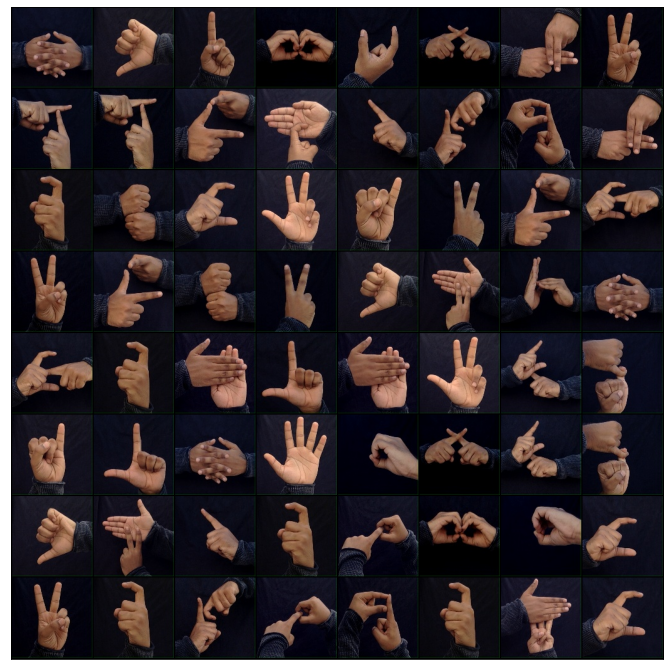

In [11]:
show_batch(raw_dl)

The above batch is a batch of image without any preprocessing or modification to the data.

Now We will create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:


1. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


2. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

First let's get the values for channel-wise data normalization. We will subtract the mean and divide the standard deviation across each channel

In [12]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])

for image, labels in raw_images:
    average += image.mean([1,2])
    standard_dev += image.std([1,2])
stats_avgs = (average / len(raw_images)).tolist()
stats_stds =  (standard_dev / len(raw_images)).tolist()
stats_avgs, stats_stds

([0.18226298689842224, 0.13947008550167084, 0.15142153203487396],
 [0.22742994129657745, 0.16096697747707367, 0.11557149887084961])

In [13]:
# Data transforms (normalization & data augmentation)

stats = (stats_avgs, stats_stds)
train_tfms = tt.Compose([# tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

Now we will split the datset into train_ds and valid_ds.

In [14]:
train_data = ImageFolder(data_dir, transform=train_tfms)
valid_data = ImageFolder(data_dir, transform=valid_tfms)
test_data = ImageFolder(data_dir, transform=valid_tfms)

In [15]:
num_train = len(train_data)
indices = list(range(num_train))
# We'll fix the random state to avoid change in the creation of train and valid data.
np.random.seed(42) 
np.random.shuffle(indices)
# Let's take 15% of the train data as validation and 10% as test
valid_size = 0.15
test_size = 0.10
val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
valid_idx, test_idx, train_idx = indices[:val_split], indices[val_split:val_split+test_split], indices[val_split+test_split:]

Next, we can create data loaders for retrieving images in batches. We'll use a batch size of 124 for now. We might increase the batch size later to utlize a larger portion of the GPU RAM. We can also reduce the batch size if we face an "out of memory" error.

In [16]:
batch_size = 75

In [17]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders 
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2, pin_memory=True)
# test_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
#     sampler=test_sampler, num_workers=2, pin_memory=True)

In [18]:
# Let's remove the unwanted variables from memory
del raw_images, average, standard_dev, raw_dl

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

In [19]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl, denorm=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        if denorm:
            images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

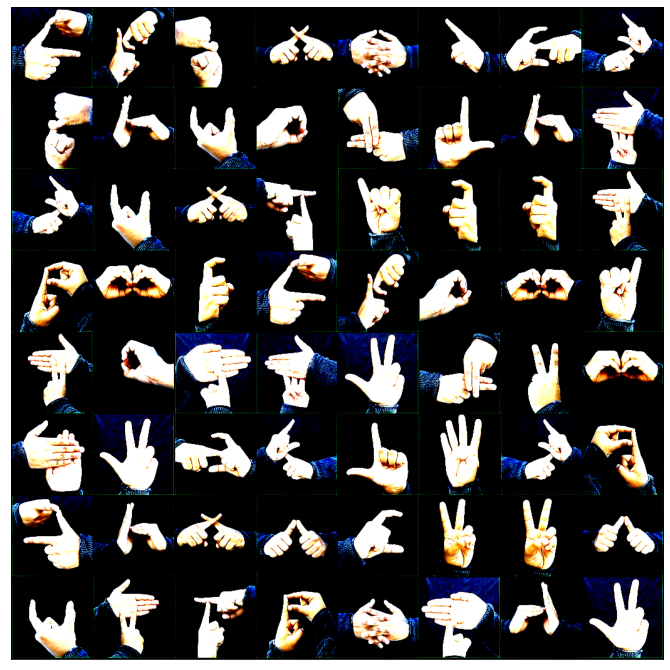

In [20]:
# Normalized and Augmented Image
show_batch(train_dl)

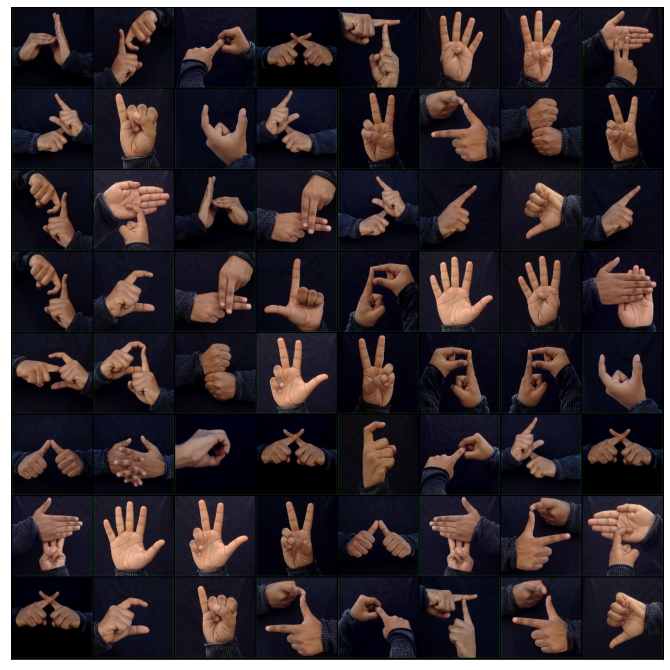

In [21]:
# Original Image
show_batch(train_dl, denorm=True)

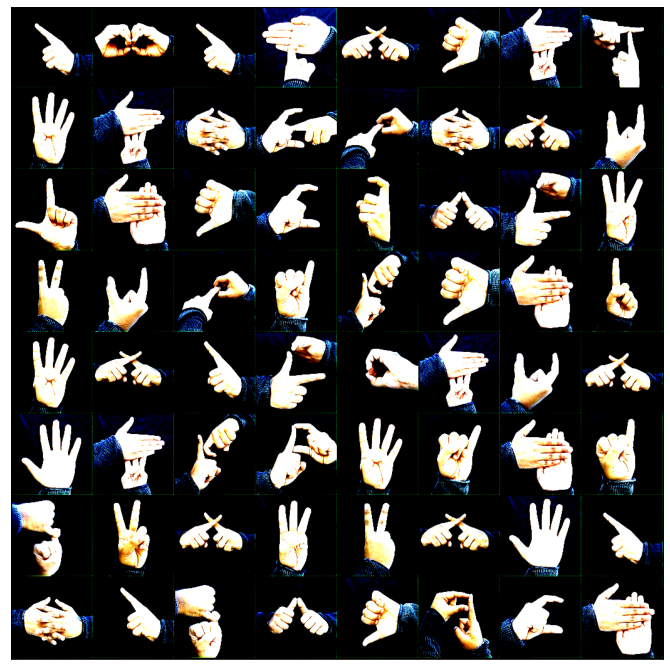

In [22]:
show_batch(valid_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [24]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:

In [26]:
#class SimpleResidualBlock(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()
        
#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.relu1(out)
#         out = self.conv2(out)
#         return self.relu2(out) + x # ReLU can be applied before or after adding the input

This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

We will use the ResNet9 architecture,

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64, pool=True) # 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 8 x 8
        self.conv5 = conv_block(512, 512, pool=True) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.classifier(out)
        return out

In [29]:
model = to_device(ResNet9(3, target_num), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.556645393371582, 'val_acc': 0.032539673149585724}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [32]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00395, train_loss: 0.0944, val_loss: 0.0002, val_acc: 1.0000
Epoch [1], last_lr: 0.00936, train_loss: 0.5532, val_loss: 1.0120, val_acc: 0.6192
Epoch [2], last_lr: 0.00972, train_loss: 0.0606, val_loss: 0.0300, val_acc: 0.9933
Epoch [3], last_lr: 0.00812, train_loss: 0.0222, val_loss: 0.0023, val_acc: 1.0000
Epoch [4], last_lr: 0.00556, train_loss: 0.0146, val_loss: 0.0029, val_acc: 0.9990
Epoch [5], last_lr: 0.00283, train_loss: 0.0030, val_loss: 0.0026, val_acc: 1.0000
Epoch [6], last_lr: 0.00077, train_loss: 0.0017, val_loss: 0.0000, val_acc: 1.0000
Epoch [7], last_lr: 0.00000, train_loss: 0.0001, val_loss: 0.0000, val_acc: 1.0000
Wall time: 34min 32s


In [34]:
train_time='10:00'

Our model trained to about 100% accuracy in under 10 minutes!

Let's plot the valdation set accuracies to study how the model improves over time.

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

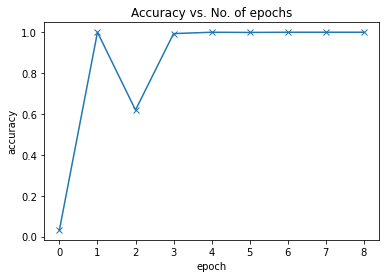

In [36]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

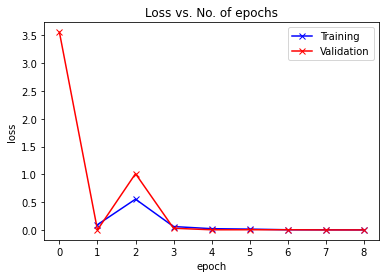

In [38]:
plot_losses(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

In [39]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_data.classes[preds[0].item()]

In [40]:
correct = [] 
for i in test_idx:
    img, lab = test_data[i]
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    correct.append(preds[0].item() == lab)
print(f"Accuracy [Test Data]: {sum(correct) / len(test_idx) * 100} %")

Accuracy [Test Data]: 100.0 %


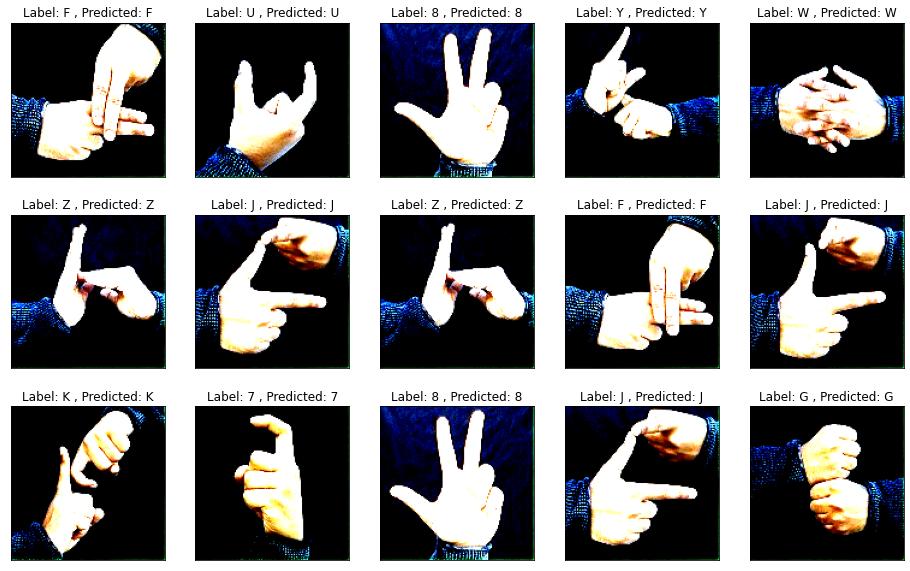

In [41]:
n_rows, n_cols, i = 3, 5, 1
fig = plt.figure(figsize=(16,10))
for index in test_idx[:15]:
    img, label = test_data[index]
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0).clamp(0,1))
    ax.set_title(f"Label: {test_data.classes[label]} , Predicted: {predict_image(img, model)}")
    i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: H , Predicted: H


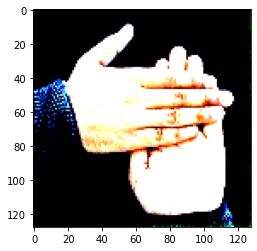

In [42]:
img, label = valid_data[19872]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_data.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Save and Commit

Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [43]:
torch.save(model.state_dict(), 'ISN-2-custom-resnet.pth')

In [44]:
import joblib
filename = 'ISN-1-custom-resnet.sav'
joblib.dump(model, filename)

c:\users\sarka\appdata\local\programs\python\python38\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


['ISN-1-custom-resnet.sav']

## Summary


Here's a summary of the different techniques used to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients.

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we did a random horizontal flip with a 50% probability. 

* **Residual connections**: One of the key things to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used a ResNet9 like architecture 

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters.

* **Learning rate scheduling**: Instead of using a fixed learning rate, we used a learning rate scheduler, which changes the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose from and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)